<a href="https://colab.research.google.com/github/HenryZumaeta/MDS_UNI/blob/Zeta/CICLO02/DL/TrabajoFinal_DL_YOLO_Exponer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Librerías

import os
import struct
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from numpy import expand_dims
from skimage.transform import resize
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.models import Model
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

# Descarga directa de drive
import gdown

# Descargar imagenes desde internet
import requests
from PIL import Image
from io import BytesIO


In [2]:
# Funcion para cargar los pesos

class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major, minor, revision = struct.unpack('3i', w_f.read(12))
            if (major * 10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)
            binary = w_f.read()
        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')

    def read_bytes(self, size):
        self.offset += size
        return self.all_weights[self.offset - size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))
                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))
                    size = np.prod(norm_layer.get_weights()[0].shape)
                    beta = self.read_bytes(size)  # bias
                    gamma = self.read_bytes(size)  # scale
                    mean = self.read_bytes(size)  # mean
                    var = self.read_bytes(size)  # variance
                    norm_layer.set_weights([gamma, beta, mean, var])
                if len(conv_layer.get_weights()) > 1:
                    bias = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2, 3, 1, 0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2, 3, 1, 0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))

    def reset(self):
        self.offset = 0


In [3]:
# Super modelo YOLO

def _conv_block(inp, convs, skip=True):
    x = inp
    skip_connection = None
    for count, conv in enumerate(convs):
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        if conv['stride'] > 1:
            x = ZeroPadding2D(((1,0),(1,0)))(x)  # Peculiar padding as darknet prefers left and top
        x = Conv2D(conv['filter'],
                   conv['kernel'],
                   strides=conv['stride'],
                   padding='valid' if conv['stride'] > 1 else 'same',
                   name='conv_' + str(conv['layer_idx']),
                   use_bias=not conv['bnorm'])(x)
        if conv['bnorm']:
            x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']:
            x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
    return add([skip_connection, x]) if skip else x

def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))
    # Layer  0 => 4
    x = _conv_block(input_image, [
        {'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
        {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
        {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
        {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}
    ])
    # Layer  5 => 8
    x = _conv_block(x, [
        {'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}
    ])
    # Layer  9 => 11
    x = _conv_block(x, [
        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}
    ])
    # Layer 12 => 15
    x = _conv_block(x, [
        {'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}
    ])
    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [
            {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}
        ])
    skip_36 = x
    # Layer 37 => 40
    x = _conv_block(x, [
        {'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}
    ])
    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [
            {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}
        ])
    skip_61 = x
    # Layer 62 => 65
    x = _conv_block(x, [
        {'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}
    ])
    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [
            {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}
        ])
    # Layer 75 => 79
    x = _conv_block(x, [
        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}
    ], skip=False)
    # Layer 80 => 82
    yolo_82 = _conv_block(x, [
        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 80},
        {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}
    ], skip=False)
    # Layer 83 => 86
    x = _conv_block(x, [
        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}
    ], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])
    # Layer 87 => 91
    x = _conv_block(x, [
        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}
    ], skip=False)
    # Layer 92 => 94
    yolo_94 = _conv_block(x, [
        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 92},
        {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}
    ], skip=False)
    # Layer 95 => 98
    x = _conv_block(x, [
        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 96}
    ], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])
    # Layer 99 => 106
    yolo_106 = _conv_block(x, [
        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 99},
        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 100},
        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 101},
        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 102},
        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 103},
        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 104},
        {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}
    ], skip=False)
    model = Model(input_image, [yolo_82, yolo_94, yolo_106])
    return model


In [4]:
# Función para descargar archivos desde drive
def descargar_archivo_desde_drive(enlace_original, nombre_archivo='archivo'):
    """
    Convierte un enlace de Google Drive a un enlace de descarga directa y descarga el archivo.

    Parámetros:
    enlace_original (str): Enlace de Google Drive en formato de vista previa.
    nombre_archivo (str): Nombre del archivo de salida.

    Retorna:
    str: El nombre del archivo descargado.
    """
    def convertir_enlace_gdown(enlace_original):
        file_id = enlace_original.split('/')[5]
        return f'https://drive.google.com/uc?id={file_id}'

    url = convertir_enlace_gdown(enlace_original)

    try:
        gdown.download(url, nombre_archivo, quiet=False)
        if not os.path.exists(nombre_archivo):
            raise FileNotFoundError("No se pudo descargar el archivo. Puede que no sea accesible.")
    except Exception as e:
        print(f"Error: {e}")
        print("Por favor, verifica los permisos del archivo o usa otro método de compartición.")
        return None
    else:
        return nombre_archivo


In [5]:
# Enlace y nombre del archivo de pesos de YOLOv3
URL = 'https://drive.google.com/file/d/18k9nuahS7ZYFyVrEIkhdEW7nhva8lR3q/view?usp=sharing'
nombre_extension = 'yolov3.weights'

# Descargar el archivo de pesos
descargar_archivo_desde_drive(URL, nombre_extension)

# Crear el modelo y cargar los pesos
yolov3 = make_yolov3_model()

# Cargar los pesos
weight_reader = WeightReader(nombre_extension)

# Definir (set) los pesos
weight_reader.load_weights(yolov3)

# Guardar el modelo entrenado
yolov3.save('model.h5')


Downloading...
From (original): https://drive.google.com/uc?id=18k9nuahS7ZYFyVrEIkhdEW7nhva8lR3q
From (redirected): https://drive.google.com/uc?id=18k9nuahS7ZYFyVrEIkhdEW7nhva8lR3q&confirm=t&uuid=b40d4479-2d25-46af-b96c-74fcfbb723d2
To: /content/yolov3.weights
100%|██████████| 248M/248M [00:08<00:00, 30.1MB/s]


loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


loading weights of convolution #101
loading weights of convolution #102
loading weights of convolution #103
loading weights of convolution #104
loading weights of convolution #105


In [6]:
# Función para cargar la imagen a detectar

def load_image_pixels(filename, shape):
    # Cargar la imagen y obtener sus dimensiones originales
    image = load_img(filename)
    width, height = image.size

    # Redimensionar la imagen
    image = load_img(filename, target_size=shape)
    image = img_to_array(image)

    # Escalar los valores de los píxeles a [0, 1]
    image = image.astype('float32')
    image /= 255.0

    # Añadir una dimensión extra para que sea compatible con el modelo
    image = expand_dims(image, 0)
    return image, width, height


In [7]:
# Crear las cajas

class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness=None, classes=None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
        return self.score

def _sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5
    boxes = []
    netout[..., :2] = _sigmoid(netout[..., :2])
    netout[..., 4:] = _sigmoid(netout[..., 4:])
    netout[..., 5:] = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h * grid_w):
        row = i // grid_w
        col = i % grid_w
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            if objectness <= obj_thresh:
                continue
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w  # center position, unit: image width
            y = (row + y) / grid_h  # center position, unit: image height
            w = anchors[2 * b] * np.exp(w) / net_w  # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h  # unit: image height
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x - w / 2, y - h / 2, x + w / 2, y + h / 2, objectness, classes)
            boxes.append(box)
    return boxes


In [8]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [9]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    return max(0, min(x2, x4) - max(x1, x3))

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax - box1.xmin, box1.ymax - box1.ymin
    w2, h2 = box2.xmax - box2.xmin, box2.ymax - box2.ymin
    union = w1 * h1 + w2 * h2 - intersect
    return float(intersect) / union

def do_nms(boxes, nms_thresh):
    if len(boxes) == 0:
        return
    nb_class = len(boxes[0].classes)
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0:
                continue
            for j in range(i + 1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    for box in boxes:
        for i in range(len(labels)):
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i] * 100)
    return v_boxes, v_labels, v_scores

def draw_boxes(filename, v_boxes, v_labels, v_scores):
    data = plt.imread(filename)
    plt.imshow(data)
    ax = plt.gca()
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        width, height = x2 - x1, y2 - y1
        rect = Rectangle((x1, y1), width, height, fill=False, color='red')
        ax.add_patch(rect)
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        plt.text(x1, y1, label, color='red')
    plt.show()


In [10]:
# Definir los anclajes
anchors = [
    [116, 90, 156, 198, 373, 326],
    [30, 61, 62, 45, 59, 119],
    [10, 13, 16, 30, 33, 23]
]

# Definir el umbral para detectar objetos
class_threshold = 0.60

# Definir las etiquetas de clasificación
labels = [
    "person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
]


Saving prueba_02.jpeg to prueba_02.jpeg
1/1 [==============================] - 5s 5s/step
[(1, 26, 26, 255), (1, 52, 52, 255), (1, 104, 104, 255)]
person 82.72188305854797
person 99.7737467288971
person 71.18144631385803
person 99.67069625854492
cat 90.26140570640564
cat 65.70945978164673
person 87.13088035583496


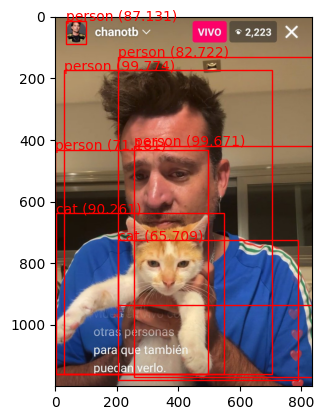

In [ ]:
# Escoger la imagen y procesarla

from google.colab import files
upload = files.upload()

for fn in upload.keys():
  photo_filename = '/content/' + fn

  # Definir el tamaño deseado de imagen
  input_w, input_h = 832, 832 #416, 416

  image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))

  # Hacer la prediccion
  yhat = yolov3.predict(image)
  print([a.shape for a in yhat])

  boxes = list()
  for i in range(len(yhat)):
    # decodifcar la salida de la red
    boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)

  # corregir los toamaños de las cajas para la imagen de entrada
  correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

  # quitar las cajas malas
  do_nms(boxes, 0.5)

  # Obtener los detalles de las cajas
  v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

  # Ver todo lo encontrado
  for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])

  # Dibujar las cajas en la imagen
  draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

1/1 [==============================] - 5s 5s/step
[(1, 26, 26, 255), (1, 52, 52, 255), (1, 104, 104, 255)]
cat 99.38339591026306
person 75.92918276786804
pizza 92.0846164226532


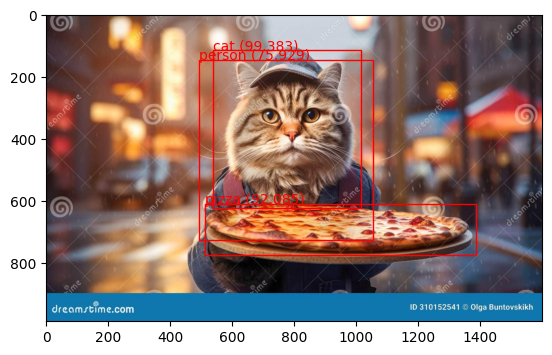

In [ ]:
# Image directo desde la web
# Escoger la imagen y procesarla

def procesar_imagen(ruta_imagen, modelo, anchors, class_threshold, input_w=832, input_h=832):
    # Cargar y preparar la imagen
    image, image_w, image_h = load_image_pixels(ruta_imagen, (input_w, input_h))

    # Hacer la predicción
    yhat = modelo.predict(image)
    print([a.shape for a in yhat])

    boxes = []
    for i in range(len(yhat)):
        # Decodificar la salida de la red
        boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)

    # Corregir los tamaños de las cajas para la imagen de entrada
    correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

    # Aplicar supresión de no máximos
    do_nms(boxes, 0.5)

    # Obtener los detalles de las cajas
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
    return v_boxes, v_labels, v_scores

def descargar_imagen(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    ruta_archivo = 'imagen_descargada.jpg'
    img.save(ruta_archivo)
    return ruta_archivo

def procesar_imagen_desde_url(url, modelo, anchors, class_threshold, input_w=832, input_h=832):
    ruta_imagen = descargar_imagen(url)
    return procesar_imagen(ruta_imagen, modelo, anchors, class_threshold, input_w, input_h)

# URL de la imagen
#url_imagen = 'https://www.shutterstock.com/image-photo/dog-cat-eat-pizza-together-600nw-1416618836.jpg'
#url_imagen = 'https://www.shutterstock.com/image-photo/gray-cute-cat-lover-pizza-260nw-2027593157.jpg'
url_imagen = 'https://thumbs.dreamstime.com/z/gatito-de-pizza-uniformado-con-una-caja-cart%C3%B3n-en-sus-patas-la-calle-luz-cinematogr%C3%A1fica-ai-generado-concepto-publicitario-para-310152541.jpg'

# Realizar la detección en la imagen desde la URL
v_boxes, v_labels, v_scores = procesar_imagen_desde_url(url_imagen, yolov3, anchors, class_threshold)

# Ver todo lo encontrado
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])

# Dibujar las cajas en la imagen descargada
draw_boxes('imagen_descargada.jpg', v_boxes, v_labels, v_scores)


Saving Perro_Gato_Pizza.png to Perro_Gato_Pizza (2).png
1/1 [==============================] - 4s 4s/step
[(1, 26, 26, 255), (1, 52, 52, 255), (1, 104, 104, 255)]
pizza 97.43642807006836
diningtable 63.92929553985596
dog 92.15410947799683
pizza 95.18038034439087


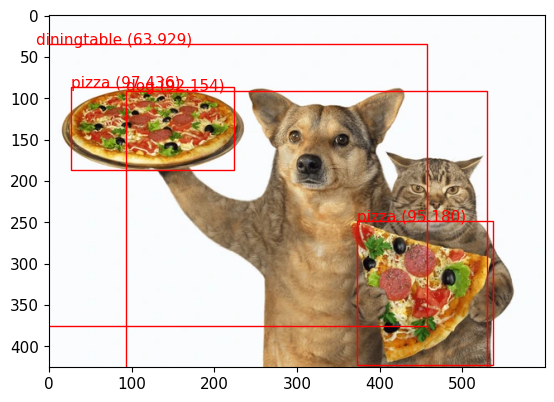

In [ ]:
# Escoger la imagen y procesarla

from google.colab import files
upload = files.upload()

for fn in upload.keys():
  photo_filename = '/content/' + fn

  # Definir el tamaño deseado de imagen
  input_w, input_h = 832, 832 #416, 416

  image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))

  # Hacer la prediccion
  yhat = yolov3.predict(image)
  print([a.shape for a in yhat])

  boxes = list()
  for i in range(len(yhat)):
    # decodifcar la salida de la red
    boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)

  # corregir los toamaños de las cajas para la imagen de entrada
  correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

  # quitar las cajas malas
  do_nms(boxes, 0.5)

  # Obtener los detalles de las cajas
  v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

  # Ver todo lo encontrado
  for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])

  # Dibujar las cajas en la imagen
  draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

Saving prueba_01.jpeg to prueba_01 (1).jpeg
1/1 [==============================] - 11s 11s/step
[(1, 26, 26, 255), (1, 52, 52, 255), (1, 104, 104, 255)]
person 65.42696356773376
dog 61.70170307159424


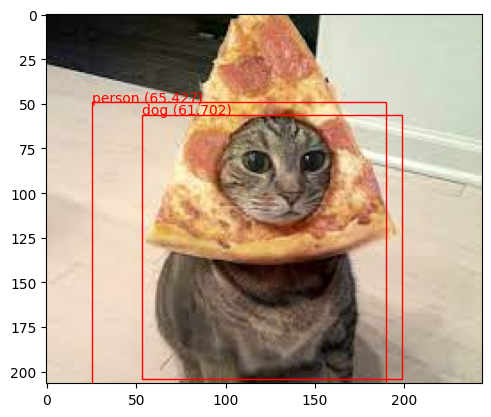

In [ ]:
# Escoger la imagen y procesarla

from google.colab import files
upload = files.upload()

for fn in upload.keys():
  photo_filename = '/content/' + fn

  # Definir el tamaño deseado de imagen
  input_w, input_h = 832, 832 #416, 416

  image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))

  # Hacer la prediccion
  yhat = yolov3.predict(image)
  print([a.shape for a in yhat])

  boxes = list()
  for i in range(len(yhat)):
    # decodifcar la salida de la red
    boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)

  # corregir los toamaños de las cajas para la imagen de entrada
  correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

  # quitar las cajas malas
  do_nms(boxes, 0.5)

  # Obtener los detalles de las cajas
  v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

  # Ver todo lo encontrado
  for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])

  # Dibujar las cajas en la imagen
  draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

# OTRAS ARQUITECTURAS

## YOLO 5

In [ ]:
import torch
from PIL import Image
from IPython.display import display

# Yolo5
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)


<ipython-input-48-b580114b9ea5>:27: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)


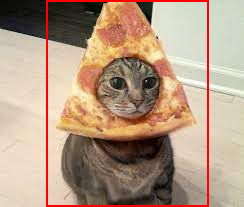

In [ ]:
img_path = "/content/Gato_pizza.png"
img = Image.open(img_path).convert("RGB")

# Hacer predicciones
results = model(img, size=20)  # Tamaño de la imagen para el modelo

# Resultados .pandas().xyxy[0] contiene las cajas delimitadoras escaladas al tamaño original de la imagen
preds = results.pandas().xyxy[0]

# Cajas delimitadoras y las etiquetas en la imagen
draw = ImageDraw.Draw(img)
font = ImageFont.load_default()

for index, row in preds.iterrows():
    # Coordenadas de la caja delimitadora
    xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])

    # Etiqueta y confianza
    label = row['name']
    confidence = round(row['confidence'] * 100)
    text = f"{label} {confidence}%"

    # Caja delimitadora
    draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)

    # Tamaño del texto
    text_size = draw.textsize(text, font=font)

    # Fondo del texto
    draw.rectangle([xmin, ymin - text_size[1], xmin + text_size[0], ymin], fill="red")

    # Dibujar texto
    draw.text((xmin, ymin - text_size[1]), text, fill="white", font=font)

display(img)

<ipython-input-64-c9ec87c1d4ec>:27: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)


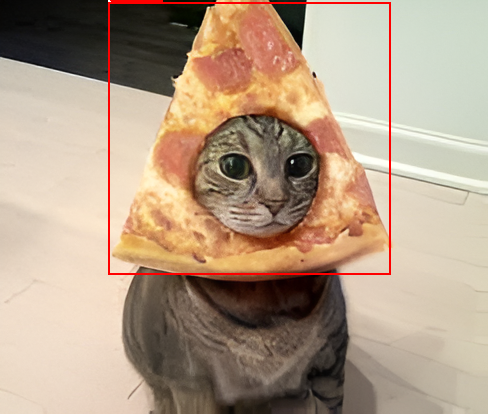

In [ ]:
img_path = "/content/Gato_pizza_mejorado.png"
img = Image.open(img_path).convert("RGB")

# Hacer predicciones
results = model(img, size=400)  # Tamaño de la imagen para el modelo

# Resultados .pandas().xyxy[0] contiene las cajas delimitadoras escaladas al tamaño original de la imagen
preds = results.pandas().xyxy[0]

# Cajas delimitadoras y las etiquetas en la imagen
draw = ImageDraw.Draw(img)
font = ImageFont.load_default()

for index, row in preds.iterrows():
    # Coordenadas de la caja delimitadora
    xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])

    # Etiqueta y confianza
    label = row['name']
    confidence = round(row['confidence'] * 100)
    text = f"{label} {confidence}%"

    # Caja delimitadora
    draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)

    # Tamaño del texto
    text_size = draw.textsize(text, font=font)

    # Fondo del texto
    draw.rectangle([xmin, ymin - text_size[1], xmin + text_size[0], ymin], fill="red")

    # Dibujar texto
    draw.text((xmin, ymin - text_size[1]), text, fill="white", font=font)

display(img)

<ipython-input-69-b55044162a43>:27: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
<ipython-input-69-b55044162a43>:27: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
<ipython-input-69-b55044162a43>:27: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)
<ipython-input-69-b55044162a43>:27: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text, font=font)


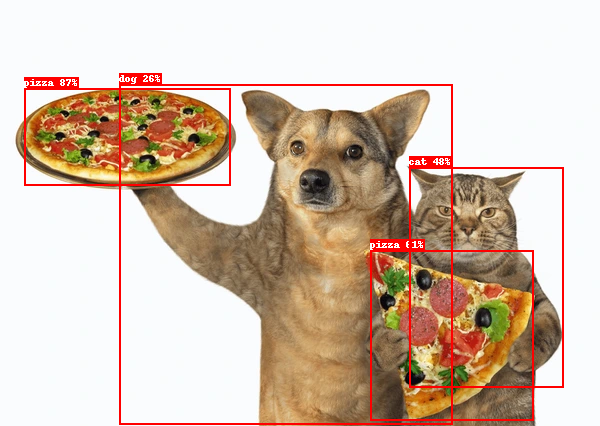

In [ ]:
img_path = "/content/Perro_Gato_Pizza.png"
img = Image.open(img_path).convert("RGB")

# Hacer predicciones
results = model(img, size=500)  # Tamaño de la imagen para el modelo

# Resultados .pandas().xyxy[0] contiene las cajas delimitadoras escaladas al tamaño original de la imagen
preds = results.pandas().xyxy[0]

# Cajas delimitadoras y las etiquetas en la imagen
draw = ImageDraw.Draw(img)
font = ImageFont.load_default()

for index, row in preds.iterrows():
    # Coordenadas de la caja delimitadora
    xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])

    # Etiqueta y confianza
    label = row['name']
    confidence = round(row['confidence'] * 100)
    text = f"{label} {confidence}%"

    # Caja delimitadora
    draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)

    # Tamaño del texto
    text_size = draw.textsize(text, font=font)

    # Fondo del texto
    draw.rectangle([xmin, ymin - text_size[1], xmin + text_size[0], ymin], fill="red")

    # Dibujar texto
    draw.text((xmin, ymin - text_size[1]), text, fill="white", font=font)

display(img)
